# Harshal Dupare | 18MA20015

Tweet Clustering

The objective of this assignment is to cluster a set of tweets into k groups, where the good k
is to determined using elbow method. The dataset consists of tweets from Boston Marathon
Bombing event which is given in the link below. The dataset is in json format. Consider only
the text part of the tweets and use the tweet id as the sample id.

You need to use Jaccard distance as the distance measure which is defined as

        𝐽(𝑃,𝑄) = 1 −|𝑃∩𝑄|/|𝑃∪𝑄|, for two different tweets P and Q.
        
|𝑃 ∩ 𝑄| denotes the number of common words in P and Q and |𝑃 ∪ 𝑄| denotes the number
of words in their union.

Dataset link: https://www3.nd.edu/~dwang5/courses/spring17/assignments/A2/Tweets.json
Please submit your code and a graph plotting the kmeans loss vs. the number of cluster in
two separate files through moodle.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import re, string
import copy
from nltk.corpus import stopwords
from scipy.spatial import distance

In [2]:
# distance function

def jaccard_distance(P,Q):
    P = np.array(P)
    Q = np.array(Q)
    return 1 - (np.sum(P*Q)/np.sum(1*((P+Q) > 0)))


In [3]:
# loading the data

tf = open("Tweets.json",'r')
s_tweet = tf.read()
tf.close()
s_tweet = s_tweet.split('\n')
tweets = [json.loads(s_tweet[i])['text'] for i in range(len(s_tweet))]
id_t = [json.loads(s_tweet[i])['id'] for i in range(len(s_tweet))]

# making the dataframe

df = pd.DataFrame()
df['id'] = id_t
df['tweets'] = tweets

### Observations
* Some tweets contain names of the accounts : we will remove them
* Some tweets contain links : will just remove them
* Some contain hash tags : we will keep them

We note that this is important features of these tweets so we just cant remove them from the tweets in preprocessing

In [4]:
# preprocessing

regex = re.compile('[%s]' % re.escape(string.punctuation))
estopwords = stopwords.words('english')

def preprocess(s):
    twt = s.lower().strip().split(' ')
    pwords = []
    
    for word in twt:
        
        word = word.strip()
        
        if word == '':
            continue
        if word == 'rt':
            continue
        if word in estopwords:
            continue
        if re.match(r'^https?:\/\/.*[\r\n]*', word):
            continue
        if re.match('^@.*', word):
            continue
        if re.match('\s', word):
            continue
        word = (((word.replace('.','')).replace(':','')).replace('!','')).strip()
        pwords.append(word)
    return (' '.join(pwords)).strip()

In [5]:
# preprocess the tweets

df['tweets'] = [preprocess(df_s) for df_s in df['tweets']]

In [6]:
df

,id,tweets
0,323906397609791488,reports marathon runners crossed finish line c...
1,323906397618196483,reports marathon runners crossed finish line c...
2,323906397735641088,reports marathon runners crossed finish line c...
3,323906397853073410,reports marathon runners crossed finish line c...
4,323906397962121216,reports marathon runners crossed finish line c...
...,...,...
246,325947086145212416,"bombing suspect unable speak sedated, intubate..."
247,325947301745029121,"bombing suspect unable speak sedated, intubate..."
248,325947340777222145,"bombing suspect unable speak sedated, intubate..."
249,325947343281205248,"bombing suspect unable speak sedated, intubate..."


In [7]:
# pool of words

pool = ''
for t in df['tweets']:
    pool+=' '+t
pool = sorted(list(set(pool.split(' ')))[1:])
print(len(pool))
print(pool)


291
['"@huffpostworld', '"@mashable', '"@nbcnews', '"if', '"reports', '#boston', '#bostonbombings', '#bostonmarathon', '#breaking', '#business', '#design', '#entrepreneurship', '#google', '#heartbreaking', '#help', '#heroes', '#innovation', '#manhunt', '#manhuntboston', '#marathon', '#marathoners', '#news', '#pittsburgh', '#playboy', '#prayforboston', '#respect', '#socialmedia', '#suspect', '#tcot', '#teamfollowback', '#tech', '#tgdn', '#us', '#usworld', '#wanted', '#watertown', '#wookala', '#worldnews', '$1', "'i", "'used", '(live', '(reuters)', '(updates)', '(via', '-', '-cc', '//', '04/15/13', '1-800-call-fbi', '140', '3', '316-es9,', '45%', '@mikandynothem', 'abc', 'aerial', 'also', 'amen', 'another', 'approach', 'area', 'arrest', 'arrested', 'at', 'attacks', 'black', 'blasts', "blessed'", 'blood', 'boat', 'bomb', 'bomber', 'bombing', 'bombing,', 'bombs', 'bos', 'boston', 'boston,', 'break', 'breaking', 'broken', 'bythere', 'call', 'car', 'cas', 'case,', 'caught', 'cellphone', 'cha

In [8]:
# create the onehot dataframe

Xdf = pd.DataFrame()
for i in range(len(pool)):
    tmp = []
    for j in range(len(df)):
        if pool[i] in df['tweets'][j].split(' '):
            tmp.append(1.0)
        else:
            tmp.append(0.0)
    Xdf[i] = tmp

Xdf

,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,289,290
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
Xdf.describe()

,0,1,2,3,4,5,6,7,8,9,...,281,282,283,284,285,286,287,288,289,290
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,...,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,0.003984,0.003984,0.003984,0.003984,0.003984,0.051793,0.019920,0.203187,0.007968,0.007968,...,0.035857,0.031873,0.003984,0.023904,0.019920,0.007968,0.023904,0.031873,0.043825,0.023904
std,0.063119,0.063119,0.063119,0.063119,0.063119,0.222051,0.140006,0.403175,0.089086,0.089086,...,0.186304,0.176012,0.063119,0.153057,0.140006,0.089086,0.153057,0.176012,0.205114,0.153057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# Kmeans code

# returns the cluster and loss
def kmeans(X,k,max_iterations=100):
    if isinstance(X, pd.DataFrame):X = X.values
    idx = np.random.choice(len(X), k, replace=False)
    # random list of centriods
    centroids = X[idx, :]
    
    P = np.argmin(distance.cdist(X, centroids, metric=jaccard_distance),axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([X[P==i,:].mean(axis=0) for i in range(k)])
        tmp = np.argmin(distance.cdist(X, centroids, jaccard_distance),axis=1)
        if np.array_equal(P,tmp):break
        P = tmp
    
    # calculating the loss
    loss = 0
    for i in range(len(P)):
        loss += jaccard_distance(centroids[P[i]],X[i, :])
    return P,loss

In [14]:
while True:
    P,loss=kmeans(Xdf,5)
    if not np.isnan(loss):
        break 
print(loss)
P

236.37975974731555


array([4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 4, 4, 4, 4, 4, 3, 3, 4, 4, 1, 3,
       3, 3, 3, 4, 4, 1, 4, 4, 4, 4, 0, 1, 1, 3, 4, 3, 3, 3, 4, 3, 4, 3,
       3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 2, 4, 4, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 1, 2, 0, 0,
       0, 0, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 0, 0,
       0, 0, 2, 4, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1], dtype=int64)

In [16]:
N = 10
max_itr  = 10
loss_c = {}
for n in range(2,N):
    itr = 0 
    while itr < max_itr:
        P,loss=kmeans(Xdf,n)
        itr+=1
        if not np.isnan(loss):
            break 
    if not np.isnan(loss):
        loss_c[n]=(loss)

C:\Users\harshal d\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\harshal d\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


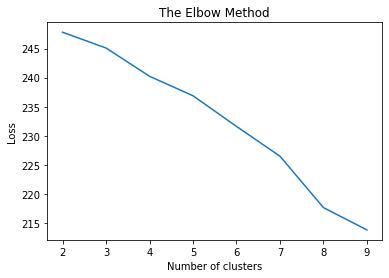

In [17]:
plt.plot(loss_c.keys(),loss_c.values())
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Loss")
plt.show()

In [28]:
for k in loss_c.keys():
    v = loss_c[k]
    print(f"For k = {k} we get the loss value as {v}")

For k = 2 we get the loss value as 247.79839755256427
For k = 3 we get the loss value as 245.08835897747147
For k = 4 we get the loss value as 240.23481236321263
For k = 5 we get the loss value as 236.8842895061388
For k = 6 we get the loss value as 231.62184968348413
For k = 7 we get the loss value as 226.50348982796694
For k = 8 we get the loss value as 217.67097636307557
For k = 9 we get the loss value as 213.83336871124104


# Observing the loss we can pick the good k = 5, as after which the loss seems linear